## Preprocessing for covariance analysis

In this notebook, we are implementing preprcessing before covariance analysis using steps provided in the following paper:
[Seydoux et al., 2016](https://doi.org/10.1093/gji/ggv531)

In [28]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal as ss
import sys

sys.path.append(os.path.join(os.path.dirname(""), os.pardir))
import coherence_analysis.utils as f

In [29]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data,_= f.load_brady_hdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data2,_= f.load_brady_hdf5(file,normalize='no')

data_noise = np.append(data, data2, axis=1)

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000118.h5"
data2,_= f.load_brady_hdf5(file,normalize='no')

data_noise = np.append(data, data2[:, :20000], axis=1)

In [30]:
sampling_rate = 1000
sample_interval = 1/sampling_rate
num_samples = len(data_noise[0])

fsize = 15
tick_size = 12
nsensors = 200
start_ch = 1000
nchannels = 3000

data_noise = data_noise[start_ch : nchannels + start_ch : int(nchannels / nsensors)]

fft of the data is calculated.

In [31]:
spectra = np.fft.rfft(data_noise[:])

frequencies = np.fft.rfftfreq(num_samples, sample_interval)

In [32]:
pp = f.covariance_preprocessing(data_noise[2], sample_interval=sample_interval)

In [33]:
len(pp[0])

50000

Text(0.5, 1.0, 'Spectra of the signal for single sensor')

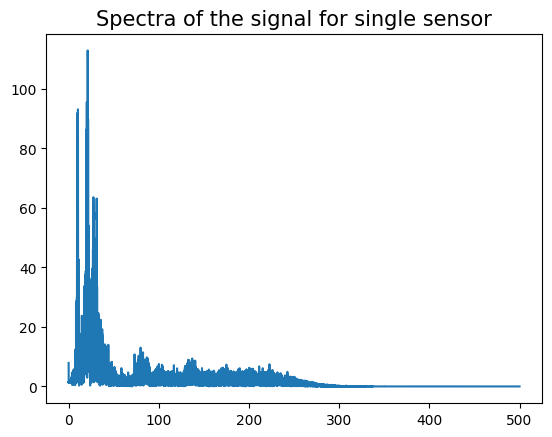

In [34]:
plt.plot(frequencies, np.abs(spectra[0]))
plt.title('Spectra of the signal for single sensor', fontsize=fsize)

Compute running average of the fft data.

In [35]:
N = int(0.33/ (frequencies[1] - frequencies[0]))

running_avg = ss.fftconvolve(np.abs(spectra), np.ones((len(spectra), N))/N, mode='same', axes=1)

# 1d
# running_avg = np.convolve(np.abs(spectra[0]), np.ones(N)/N, mode='same')

Text(0.5, 1.0, 'Running average of the signal for single sensor')

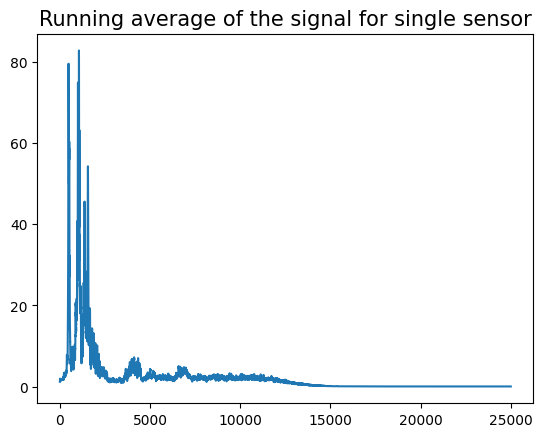

In [36]:
plt.plot(running_avg[0].real)
plt.title('Running average of the signal for single sensor', fontsize=fsize)

d:\CSM\Mines_Research\Repositories\Coherence_Analyses\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\CSM\Mines_Research\Repositories\Coherence_Analyses\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Whitened signal for single sensor')

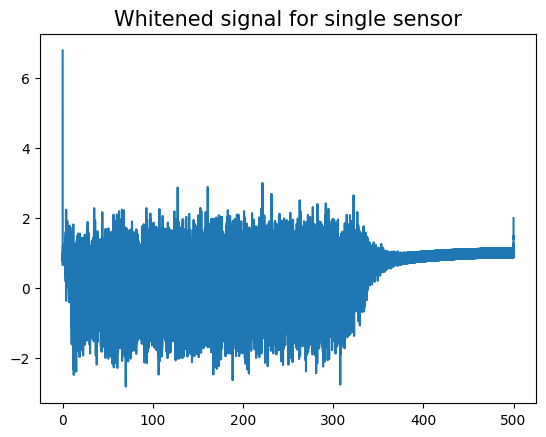

In [37]:
spectral_whitened = spectra/running_avg

plt.plot(frequencies, spectral_whitened[0])
plt.title('Whitened signal for single sensor', fontsize=fsize)

Text(0.5, 1.0, 'Whitened signal for single sensor in time domain')

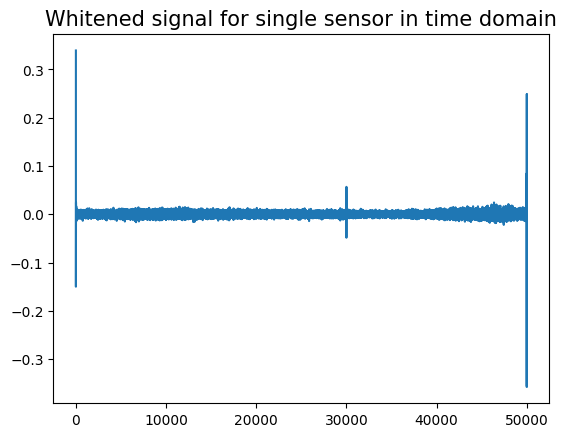

In [38]:
whitened_time = np.fft.irfft(spectral_whitened)

plt.plot(whitened_time[0])
plt.title('Whitened signal for single sensor in time domain', fontsize=fsize)

Compute running average for time domain normalization.

In [39]:
N = int(1.25 * sampling_rate)

running_avg = ss.fftconvolve(np.abs(whitened_time), np.ones((len(whitened_time), N))/N, mode='same', axes=1)

# 1d
# running_avg = np.convolve(np.abs(np.fft.irfft(spectral_whitened)), np.ones(N)/N, mode='same')

Compute the prepocessed data.

Text(0.5, 1.0, 'Preprocessed signal for single sensor in time domain')

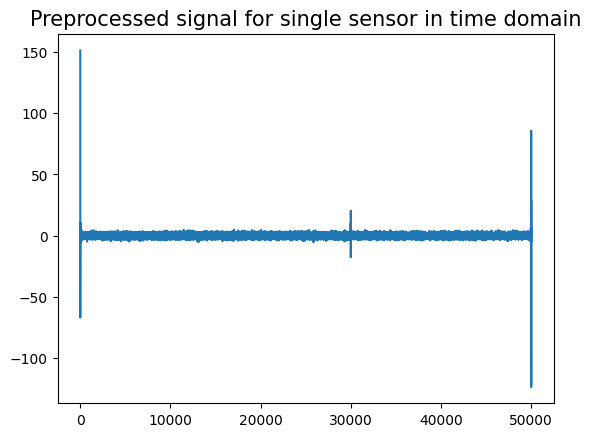

In [40]:
preprocessed = whitened_time/running_avg

plt.plot(preprocessed[0])
plt.title('Preprocessed signal for single sensor in time domain', fontsize=fsize)

## Use preprocessed data for coherence analysis

In [41]:
subwindow_len = 1
overlap = 0.5

In [42]:
covariance, frequencies = f.covariance(
    preprocessed,
    subwindow_len,
    overlap,
    sample_interval=0.001,
)

In [43]:
num_frames = covariance.shape[0]
eig_ratios_covariance = np.empty(num_frames)

for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(covariance[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_covariance[d] = eigenvals[0] / np.sum(eigenvals)

C:\Users\issah\AppData\Local\Temp\ipykernel_24348\2718592155.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  eig_ratios_covariance[d] = eigenvals[0] / np.sum(eigenvals)


Text(0.5, 1.0, 'Eigenvalue ratios of the covariance matrix')

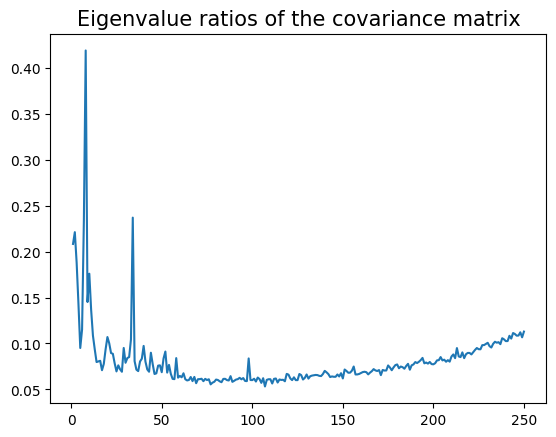

In [44]:
plt.plot(frequencies[1:-250], eig_ratios_covariance[1:-250])
plt.title('Eigenvalue ratios of the covariance matrix', fontsize=fsize)

Compare covariance analysis with coherence analysis.

In [45]:
coherence, frequencies = f.welch_coherence(
    data[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
eig_ratios_coherence = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_coherence[d] = eigenvals[0] / np.sum(eigenvals)

Text(0.5, 1.0, 'Eigenvalue ratios for coherence matrices')

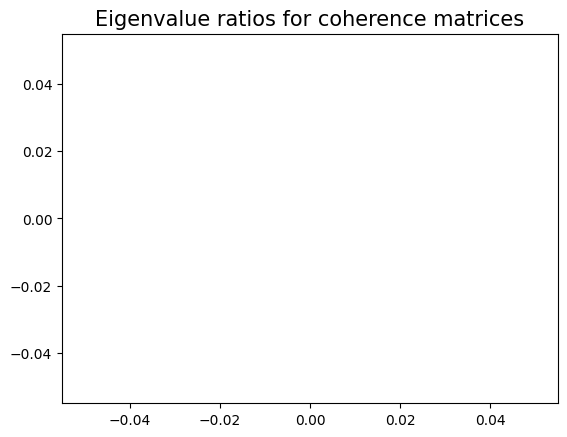

In [46]:
plt.plot(frequencies[1:-700], eig_ratios_coherence[1:-700])
plt.title('Eigenvalue ratios for coherence matrices', fontsize=fsize)

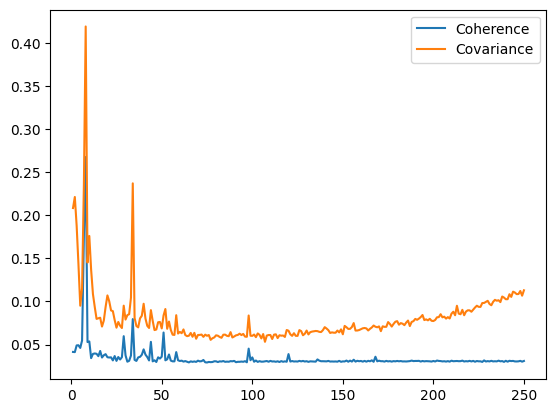

In [47]:
plt.plot(frequencies[1:-250], eig_ratios_coherence[1:-250], label='Coherence')
plt.plot(frequencies[1:-250], eig_ratios_covariance[1:-250], label='Covariance')
plt.legend()